# Coconut Maturity Detection using Deep Learning

### Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Define Image sizes and Plot images

In [3]:
IMAGE_SIZE = (128, 128)

train_path = "D:/Tasks/Coconut/dataset/train"
val_path = "D:/Tasks/Coconut/dataset/val"

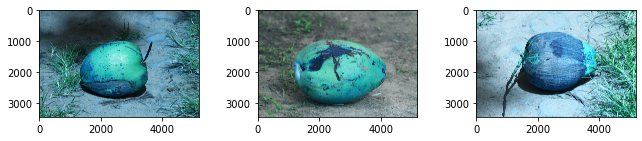

In [4]:
import random
from PIL import Image 

images = []
for folder in os.listdir(train_path):
    for image in os.listdir(train_path + '/' + folder):
        images.append(os.path.join(train_path, folder, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(3):
  n += 1
  random_img = random.choice(images)
  imgs = cv2.imread(random_img)
  plt.subplot(4, 4, n)
  plt.imshow(imgs)

plt.show()

### Augment Train and Test data

In [5]:
train_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )

train_set = train_generator.flow_from_directory(train_path,
                                                target_size = IMAGE_SIZE,
                                                shuffle=True,
                                                batch_size = 32 )


test_set = ImageDataGenerator().flow_from_directory(val_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32, 
                                            shuffle=False )

Found 1054 images belonging to 4 classes.
Found 252 images belonging to 4 classes.


In [6]:
CLASS_NUM = 4

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10,10))
for i in range(3):
    batch=next(train_set)   
    img=batch[0][0]  
    image = img.astype('uint8')
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis('off')

## Defining and implementing the base models

### DenseNet201

In [7]:
denseNet = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg",
    classes=CLASS_NUM,
)

In [8]:
denseNet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

In [9]:
for layer in denseNet.layers[:-5]:
    layer.trainable = False

### ResNet50

In [10]:
resNet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg",
    classes=CLASS_NUM,
)

In [11]:
resNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [12]:
for layer in resNet.layers[:-4]:
    layer.trainable = False

### MobileNet

In [13]:
mobileNet = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg",
    classes=CLASS_NUM,
)

In [14]:
mobileNet.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [15]:
for layer in mobileNet.layers[:-3]:
    layer.trainable = False

### Implementation of Ensemble Model

In [16]:
input_layer = tf.keras.layers.Input(shape=(128,128,3))

In [17]:
denseNet_preprocess = tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input)(input_layer)

densenet_output = denseNet(denseNet_preprocess)
densenet_output = tf.keras.layers.Flatten()(densenet_output)

In [18]:
resNet_preprocess = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input)(input_layer)

resNet_output = resNet(resNet_preprocess)
resNet_output = tf.keras.layers.Flatten()(resNet_output)

In [19]:
mobileNet_preprocess = tf.keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input)(input_layer)

mobileNet_output = mobileNet(mobileNet_preprocess)
mobileNet_output = tf.keras.layers.Flatten()(mobileNet_output)

In [20]:
ensemble_output = tf.keras.layers.concatenate([densenet_output, resNet_output, mobileNet_output])

ensemble_output = tf.keras.layers.Dense(128, activation='relu')(ensemble_output)
ensemble_output = tf.keras.layers.Dense(64, activation='relu')(ensemble_output)

ensemble_output = tf.keras.layers.Dense(CLASS_NUM, activation='softmax')(ensemble_output)

In [21]:
ensemble_model = keras.models.Model(inputs=input_layer, outputs=ensemble_output)

### Compile and train the model

In [22]:
ensemble_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_4[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_4[0][0]']            

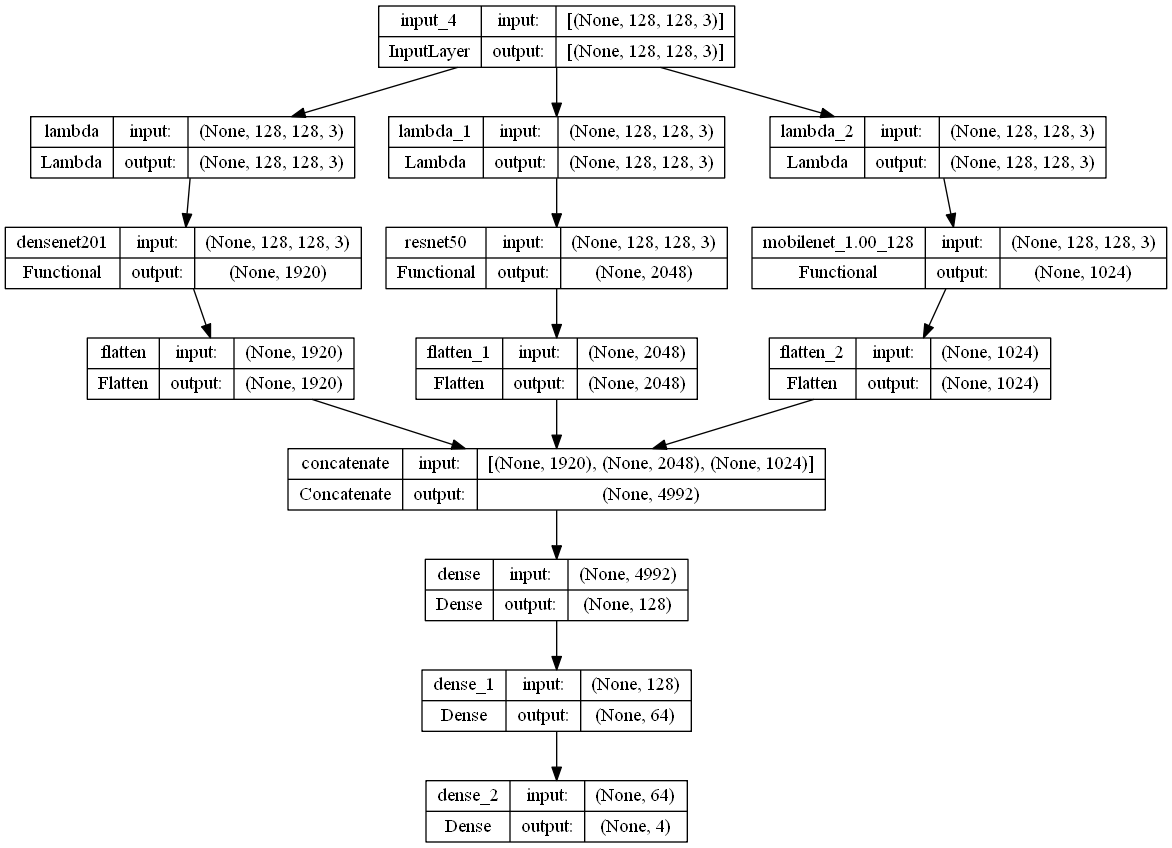

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(ensemble_model, to_file='architectureNW.png',show_shapes=True, show_layer_names=True)

In [25]:
from keras import callbacks

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [26]:
ensemble_history = ensemble_model.fit(
    train_set,
    validation_data=test_set,
    epochs=30,
    callbacks=[earlystopping]
)

Epoch 1/30
33/33 [==============================] - 560s 17s/step - loss: 0.4853 - accuracy: 0.7770 - val_loss: 0.2937 - val_accuracy: 0.8651
Epoch 2/30
33/33 [==============================] - 541s 17s/step - loss: 0.3586 - accuracy: 0.8368 - val_loss: 0.2574 - val_accuracy: 0.8730
Epoch 3/30
33/33 [==============================] - 539s 16s/step - loss: 0.2767 - accuracy: 0.8719 - val_loss: 0.3481 - val_accuracy: 0.8492
Epoch 4/30
33/33 [==============================] - 524s 16s/step - loss: 0.2818 - accuracy: 0.8729 - val_loss: 0.2281 - val_accuracy: 0.9087
Epoch 5/30
33/33 [==============================] - 484s 15s/step - loss: 0.2326 - accuracy: 0.8890 - val_loss: 0.2472 - val_accuracy: 0.8968
Epoch 6/30
33/33 [==============================] - 481s 15s/step - loss: 0.2085 - accuracy: 0.9032 - val_loss: 0.2278 - val_accuracy: 0.9008
Epoch 7/30
33/33 [==============================] - 487s 15s/step - loss: 0.1937 - accuracy: 0.9127 - val_loss: 0.1948 - val_accuracy: 0.9087
Epoch 

### Save the best model

In [27]:
best_model = ensemble_model
best_model.save('best_model_coconut_maturity_v2_6_FINAL.h5')

### Load the best model

In [28]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model_coconut_maturity_v2_6_FINAL.h5')

## Evaluating the model

### Train and Test Accuracy, Loss

In [29]:
train_loss, train_acc = loaded_model.evaluate(train_set)

33/33 [==============================] - 424s 13s/step - loss: 0.1169 - accuracy: 0.9545


In [30]:
test_loss, test_acc = loaded_model.evaluate(test_set)

8/8 [==============================] - 93s 12s/step - loss: 0.1709 - accuracy: 0.9484


### Learning Curves

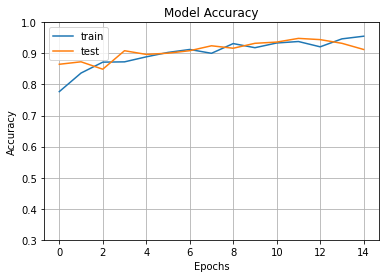

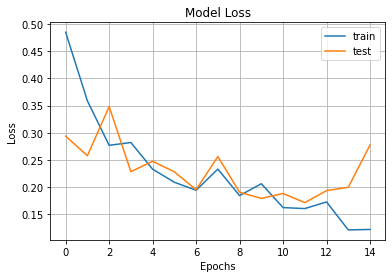

In [31]:
fig1 = plt.gcf()
plt.plot(ensemble_history.history['accuracy'])
plt.plot(ensemble_history.history['val_accuracy'])
plt.axis(ymin=0.3,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


plt.plot(ensemble_history.history['loss'])
plt.plot(ensemble_history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Making predictions on the test data

In [32]:
prediction = loaded_model.predict(test_set) 
pred_classes=np.argmax(prediction,axis=1)

8/8 [==============================] - 73s 8s/step


In [33]:
test_labels = test_set.classes

### Precision, Recall and F1-Score

In [34]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        50
           1       1.00      0.93      0.97        60
           2       0.99      0.91      0.95        92
           3       0.93      1.00      0.96        50

    accuracy                           0.95       252
   macro avg       0.94      0.96      0.95       252
weighted avg       0.95      0.95      0.95       252



### Confusion Matrix

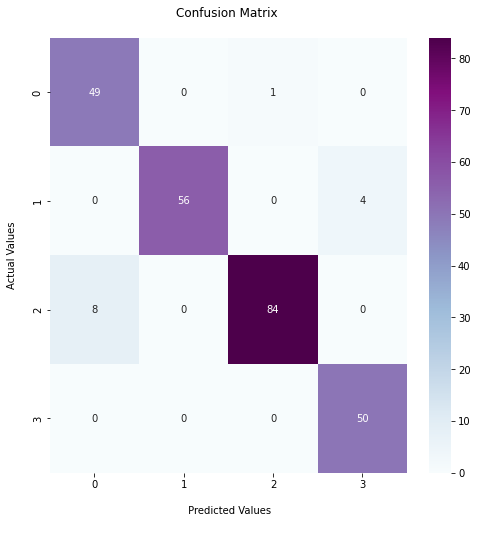

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8,8))
fx=sns.heatmap(confusion_matrix(test_labels,pred_classes), annot=True, fmt="d",cmap="BuPu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(["0","1","2","3"])
fx.yaxis.set_ticklabels(["0","1","2","3"])
plt.show()

### Predict the maturity

In [40]:
classes = ['Immatured_Bunch', 'Immatured_Singles', 'Matured_Bunch', 'Matured_Singles']

1/1 [==============================] - 0s 119ms/step
Result Array [[3.4474695e-06 2.1131679e-04 3.3357603e-06 9.9978191e-01]]
Max value 0.9997819
Max class [3]
Classification:  Matured_Singles


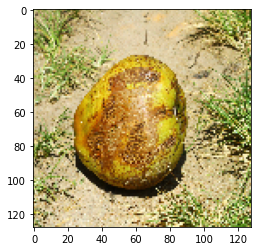

In [46]:
img_path = "D:/Tasks/Coconut/dataset/val/Matured_Singles/IMG_9604.JPG"

img = tf.keras.utils.load_img(img_path, target_size= IMAGE_SIZE)
img = tf.keras.utils.img_to_array(img)
img = np.expand_dims(img, axis=0)

preds = loaded_model.predict(img)
print("Result Array", preds)

plt.imshow(tf.keras.utils.load_img(img_path, target_size= IMAGE_SIZE))

print("Max value", np.amax(preds))
print("Max class", np.argmax(preds,axis=1))
print("Classification: ",classes[int(np.argmax(preds,axis=1))])